# Case study: type 2 diabetes (T2D)

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import normalize, minmax_scale
from scipy.stats import pearsonr, spearmanr, f_oneway, norm
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import scanpy as sc
import torch
import torch.nn as nn
torch.cuda.set_device(1)
import pybedtools
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)
from scipy.sparse import load_npz
from scipy.sparse import coo_matrix
from scipy.io import mmread

from CauTrigger.utils import set_seed, select_features
from CauTrigger.model import CauTrigger3L, CauTrigger2L, CauTrigger1L
set_seed(42)

In [9]:
data_dir = '/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/BenchmarkGRN/T2D/data/'
output_dir = '/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/BenchmarkGRN/T2D/output/'
os.makedirs(output_dir, exist_ok=True)

In [10]:
TF = pd.read_csv(os.path.join(data_dir, 'filtered_TF_pseudobulk.csv'), index_col=0).T  # 781 metacell x 455 TF
RE = pd.read_csv(os.path.join(data_dir, 'filtered_RE_pseudobulk.csv'), index_col=0).T  # 781 metacell x 10446 RE
TG = pd.read_csv(os.path.join(data_dir, 'filtered_TG_pseudobulk.csv'), index_col=0).T  # 781 metacell x 2510 TG

In [15]:
t2d_samples = ["C0019", "C0024", "C0021", "A0024", "A0031", "C0023"]
pre_samples = ["A0011", "A0028", "A0029", "C0013", "C0014", "A0030", "A0021", "C0022"]
control_samples = ["C0026", "C0027", "A0019", "A0033", "A0027", "C0025"]

In [16]:
barcodes = pd.read_csv(data_dir + 'beta_RNA.barcodes', header=None)  # 33011，来自20个人
barcodes[['sample_id', 'cell_barcode']] = barcodes[0].str.split('_', expand=True)
barcodes['state'] = [
    'control' if a in control_samples else
    'pre' if a in pre_samples else
    't2d' for a in barcodes['sample_id']
]
barcodes = barcodes.set_index(0)  # 如果还没有设置 index
filtered_barcodes = barcodes.loc[TF.index]

In [17]:
aligned_values = filtered_barcodes.state.values  # 这是metacell每个的celltype
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
numeric_values = label_encoder.fit_transform(aligned_values)  # 这是metacell每个的数字标签

In [18]:
label_map = pd.DataFrame({
    "celltype": label_encoder.classes_,
    "label": np.arange(len(label_encoder.classes_))
})
celltypes = label_encoder.classes_

In [8]:
# TG--RE interaction matrix
sparse_matrix = load_npz(os.path.join(data_dir, "TG_RE_interaction_matrix.npz"))  # 2510 x 10446
sparse_matrix_index = pd.read_csv(os.path.join(data_dir, "TG_RE_interaction_matrix_rows.txt")).values.flatten()  # TG
sparse_matrix_column = pd.read_csv(os.path.join(data_dir, "TG_RE_interaction_matrix_cols.txt")).values.flatten()  # RE

In [10]:
adata1 = sc.AnnData(X=np.array(TG))
adata1.var_names = np.array(TG.columns)
adata1.obs_names = np.array(TG.index)
adata1.obs["labels"] = numeric_values
adata1.obs["celltype"] = aligned_values

model321_1 = CauTrigger1L(
    adata1,
    n_latent=10,
    n_hidden=128,
    n_state=len(np.unique(aligned_values)),
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=False,
    dpd_linear=False,
    # update_down_weight=True,
    init_thresh=0.00,
    attention=False,
    att_mean=False,
)
model321_1.train(max_epochs=300, batch_size=32, stage_training=True, weight_scheme="pbmc")

training: 100%|██████████| 300/300 [05:21<00:00,  1.07s/it]


In [11]:
weight_df_weight1 = model321_1.get_up_feature_weights(normalize=True, method="Grad", sort_by_weight=False)
causal_factors_layer1_indices = np.argsort(weight_df_weight1[0]['weight'])[-1000:][::-1]

adata2 = sc.AnnData(RE)
adata2.var_names = np.array(RE.columns)
adata2.obs_names = np.array(RE.index)
adata2.obs["labels"] = numeric_values
adata2.obs["celltype"] = aligned_values
adata2.obsm['X_down'] = adata1.X[:, causal_factors_layer1_indices]
adata2.uns['TG_names'] = adata1[:, causal_factors_layer1_indices].var_names.values

In [12]:
model321_2 = CauTrigger2L(
    adata2,
    n_latent=10,
    n_hidden=128,
    n_state=len(np.unique(aligned_values)),
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=False,
    dpd_linear=False,
    # update_down_weight=True,
    init_thresh=0.00,
    attention=False,
    att_mean=False,
)

model321_2.train(max_epochs=300, batch_size=32, stage_training=True, weight_scheme="pbmc")

training: 100%|██████████| 300/300 [07:18<00:00,  1.46s/it]


In [13]:
weight_df_weight2 = model321_2.get_up_feature_weights(normalize=True, method="Grad", sort_by_weight=False)
causal_factors_layer2_indices = np.argsort(weight_df_weight2[0]['weight'])[-5000:][::-1]

adata3 = sc.AnnData(TF)
adata3.var_names = np.array(TF.columns)
adata3.obs_names = np.array(TF.index)
adata3.obs["labels"] = numeric_values
adata3.obs["celltype"] = aligned_values
adata3.obsm['X_down2'] = adata2.obsm['X_down'].copy()
adata3.obsm['X_down1'] = adata2.X[:, causal_factors_layer2_indices]
adata3.uns['TG_names'] = adata2.uns['TG_names'].copy()
adata3.uns['RE_names'] = adata2[:, causal_factors_layer2_indices].var_names.values

In [14]:
model321_3 = CauTrigger3L(
    adata3,
    n_latent=10,
    n_hidden=128,
    n_state=len(np.unique(aligned_values)),
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=False,
    dpd_linear=False,
    # update_down_weight=True,
    init_thresh=0.00,
    attention=False,
    att_mean=False,
    decoder_down2_sparse=False,
)

model321_3.train(max_epochs=300, batch_size=32, stage_training=True, weight_scheme="pbmc")

training: 100%|██████████| 300/300 [07:09<00:00,  1.43s/it]


In [15]:
celltype_trigger_dict = {}
for idx, celltype in enumerate(celltypes):
    weights_df, _ = model321_3.get_up_feature_weights(method="SHAP", class_idx=idx, sort_by_weight=False)
    weights_df.index = TF.columns
    celltype_trigger_dict[celltype] = weights_df['weight'].sort_values(ascending=False).nlargest(20).index

In [16]:
celltype_trigger_dict

{'control': Index(['RFX3', 'FOXP2', 'JUN', 'JUND', 'KLF6', 'SREBF1', 'SP4', 'NR1D2',
        'HES1', 'FOS', 'NFIA', 'PBX1', 'STAT1', 'NR6A1', 'SOX4', 'ELF2',
        'ZNF708', 'PAX6', 'FOXK2', 'MEIS1'],
       dtype='object'),
 'pre': Index(['FOS', 'RFX3', 'HES1', 'RORA', 'ETV5', 'GLIS3', 'TCF4', 'FOXO3', 'KLF6',
        'NR6A1', 'JUNB', 'XBP1', 'JUN', 'PBX1', 'RORB', 'NR1D2', 'MEF2A', 'SP4',
        'FOXK1', 'TFEB'],
       dtype='object'),
 't2d': Index(['FOXP2', 'RORA', 'TCF4', 'KLF10', 'TRPS1', 'FOS', 'NFATC2', 'PAX6',
        'KLF7', 'JUNB', 'KLF13', 'JUN', 'GLIS3', 'NEUROD1', 'ZNF708', 'NR1D1',
        'FOXO3', 'ZKSCAN1', 'PBX3', 'ELF2'],
       dtype='object')}

In [19]:
adata_tg = sc.AnnData(X=np.array(pd.concat([TF,RE,TG], axis=1)))
adata_tg.obs["celltype"] = aligned_values

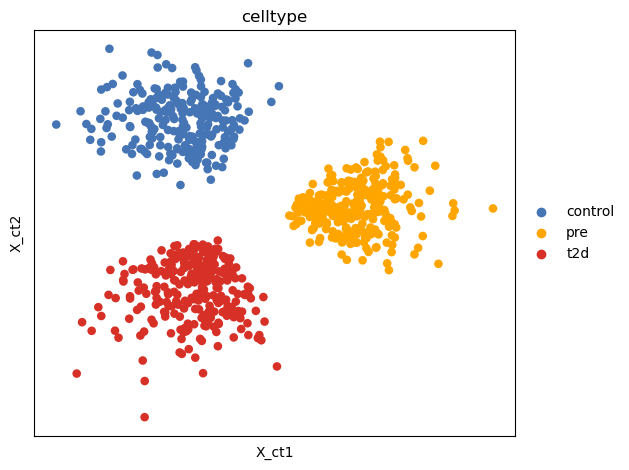

In [20]:
adata_tg.obsm['X_ct'] = model321_3.get_model_output()['latent'][:, :2]
sc.pl.embedding(adata_tg, basis='X_ct', color='celltype', show=False, palette = {"control": "#4575B4", "pre": "orange", 't2d': '#D73027'})
plt.tight_layout()
plt.savefig(output_dir + 'tg_Z.pdf')

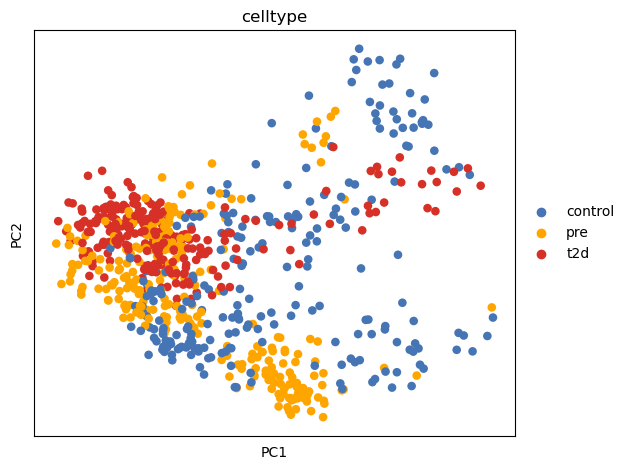

In [20]:
# PCA
sc.tl.pca(adata_tg)
sc.pl.pca(adata_tg, color='celltype', show=False, palette = {"control": "#4575B4", "pre": "orange", 't2d': '#D73027'})
plt.tight_layout()
# plt.savefig(output_dir + 'tg_PCA.pdf')

In [27]:
adata_tg.obs.to_csv(output_dir+'pca_df_label.csv')

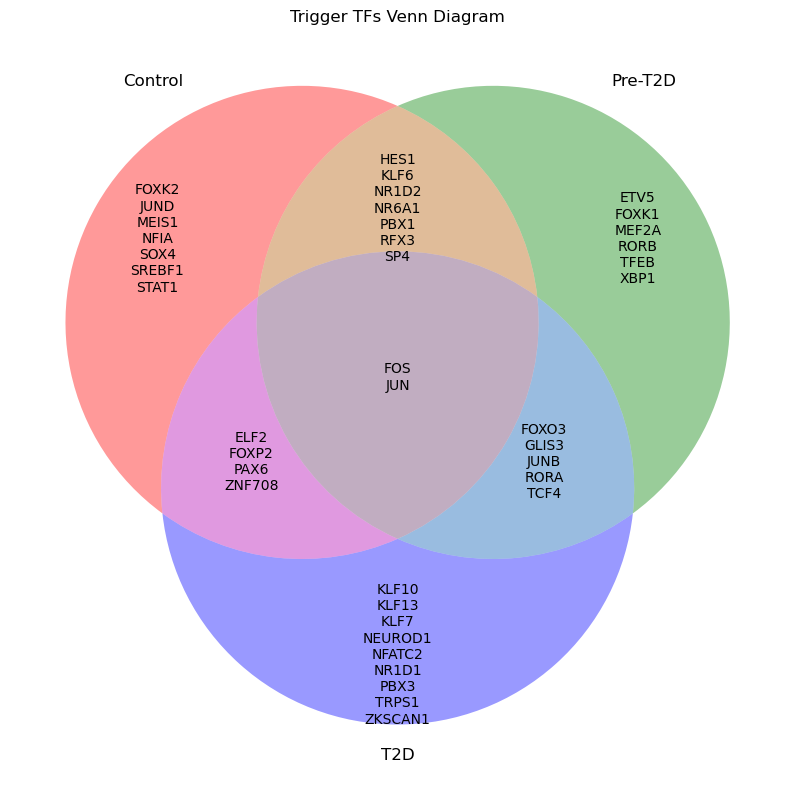

In [19]:
from matplotlib_venn import venn3_unweighted

control = set(celltype_trigger_dict['control'])
pre = set(celltype_trigger_dict['pre'])
t2d = set(celltype_trigger_dict['t2d'])

# 画图
plt.figure(figsize=(10, 8))
v = venn3_unweighted([control, pre, t2d], set_labels=('Control', 'Pre-T2D', 'T2D'))

# 填写基因名
regions = {
    '100': control - pre - t2d,
    '010': pre - control - t2d,
    '001': t2d - control - pre,
    '110': control & pre - t2d,
    '101': control & t2d - pre,
    '011': pre & t2d - control,
    '111': control & pre & t2d
}

for region_id, genes in regions.items():
    label = v.get_label_by_id(region_id)
    if label:
        gene_text = '\n'.join(sorted(genes)) if genes else ''
        label.set_text(gene_text)

plt.title("Trigger TFs Venn Diagram")
plt.tight_layout()
plt.savefig(output_dir + 'TF_venn.pdf')
plt.show()

In [22]:
adata_TF = adata3.copy()
adata_down = sc.AnnData(adata3.obsm['X_down2'])
adata_down.var_names = adata3.uns['TG_names']
adata_down.obs_names = TG.index.values
adata_down.obs = adata_TF.obs.copy()
adata_down.obsm['X_ct'] = model321_3.get_model_output()['latent'][:, :2]

In [23]:
def plot_vector_field(adata,pert_Gene=None,pert_celltype=None,state_obs=None,embedding_name=None,
                      sampled_fraction=1, min_mass=0.008,scale=0.1, save_dir=None,smooth=0.8,n_grid=40,
                     n_suggestion=12,show=True,dot_size=None,run_suggest_mass_thresholds=False,direction=None,n_neighbors=None,palette=None):
    from scipy import sparse
    from sklearn.neighbors import NearestNeighbors
    from velocyto.estimation import colDeltaCorpartial
    from scipy.stats import norm as normal
    import math

    def estimate_transition_prob(adata, embedding_name,sampled_fraction, n_neighbors=None, sigma_corr=0.005):
        sampling_probs = (0.5, 0.1)
        X = adata.layers["imputed_count"].transpose().copy()
        delta_X = adata.layers["delta_X"].transpose().copy()
        embedding = adata.obsm[embedding_name].copy()
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=4)
        nn.fit(embedding)
        embedding_knn = nn.kneighbors_graph(mode="connectivity")
        neigh_ixs = embedding_knn.indices.reshape((-1, n_neighbors + 1))
        p = np.linspace(sampling_probs[0], sampling_probs[1], neigh_ixs.shape[1])
        p = p / p.sum()
        sampling_ixs = np.stack([np.random.choice(neigh_ixs.shape[1],
                                                  size=(int(sampled_fraction * (n_neighbors + 1)),),
                                                  replace=False,
                                                  p=p) for i in range(neigh_ixs.shape[0])], 0)
        neigh_ixs = neigh_ixs[np.arange(neigh_ixs.shape[0])[:, None], sampling_ixs]
        nonzero = neigh_ixs.shape[0] * neigh_ixs.shape[1]
        embedding_knn = sparse.csr_matrix((np.ones(nonzero),
                                           neigh_ixs.ravel(),
                                           np.arange(0, nonzero + 1, neigh_ixs.shape[1])),
                                          shape=(neigh_ixs.shape[0],
                                                 neigh_ixs.shape[0]))
        adata.uns['neigh_ixs'] = neigh_ixs.copy()
        corrcoef = colDeltaCorpartial(X, delta_X, neigh_ixs)
        if np.any(np.isnan(corrcoef)):
            corrcoef[np.isnan(corrcoef)] = 1
        transition_prob = np.exp(corrcoef / sigma_corr) * embedding_knn.A
        transition_prob /= transition_prob.sum(1)[:, None]
        adata.obsm['embedding_knn'] = embedding_knn.copy()
        adata.obsp['transition_prob'] = transition_prob.copy()

    def calculate_embedding_shift(adata, embedding_name):
        transition_prob = adata.obsp['transition_prob'].copy()
        embedding = adata.obsm[embedding_name].copy()
        embedding_knn = adata.obsm['embedding_knn'].copy()
        unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
        with np.errstate(divide='ignore', invalid='ignore'):
            unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)
            np.fill_diagonal(unitary_vectors[0, ...], 0)
            np.fill_diagonal(unitary_vectors[1, ...], 0)
        delta_embedding = (transition_prob * unitary_vectors).sum(2)
        delta_embedding -= (embedding_knn.A * unitary_vectors).sum(2) / embedding_knn.sum(1).A.T
        delta_embedding = delta_embedding.T
        adata.obsm['delta_embedding'] = delta_embedding.copy()

    def calculate_p_mass(adata,state_obs,pert_celltype, embedding_name, smooth, n_grid, n_neighbors=None):
        steps = (n_grid, n_grid)
        embedding = adata.obsm[embedding_name].copy()
        adata_tmp = adata.copy()
        adata_tmp.obsm['delta_embedding'][~adata_tmp.obs[state_obs].isin(pert_celltype)] = 0
        delta_embedding = adata_tmp.obsm['delta_embedding'].copy()
        grs = []
        for dim_i in range(embedding.shape[1]):
            m, M = np.min(embedding[:, dim_i]), np.max(embedding[:, dim_i])
            m = m - 0.025 * np.abs(M - m)
            M = M + 0.025 * np.abs(M - m)
            gr = np.linspace(m, M, steps[dim_i])
            grs.append(gr)
        meshes_tuple = np.meshgrid(*grs)
        gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        nn.fit(embedding)
        dists, neighs = nn.kneighbors(gridpoints_coordinates)
        std = np.mean([(g[1] - g[0]) for g in grs])
        gaussian_w = normal.pdf(loc=0, scale=smooth * std, x=dists)
        total_p_mass = gaussian_w.sum(1)
        UZ = (delta_embedding[neighs] * gaussian_w[:, :, None]).sum(1) / np.maximum(1, total_p_mass)[:,None]
        magnitude = np.linalg.norm(UZ, axis=1)
        flow_embedding = embedding
        flow_grid = gridpoints_coordinates
        flow = UZ
        flow_norm = UZ / np.percentile(magnitude, 99.5)
        flow_norm_magnitude = np.linalg.norm(flow_norm, axis=1)
        adata.uns['total_p_mass'] = total_p_mass.copy()
        adata.uns['flow_grid'] = flow_grid.copy()
        adata.uns['flow'] = flow.copy()

    def suggest_mass_thresholds(adata, embedding_name, n_suggestion,save_dir, s=1, n_col=4):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        min_ = total_p_mass.min()
        max_ = total_p_mass.max()
        suggestions = np.linspace(min_, max_ / 2, n_suggestion)
        n_rows = math.ceil(n_suggestion / n_col)
        fig, ax = plt.subplots(n_rows, n_col, figsize=[5 * n_col, 5 * n_rows])
        if n_rows == 1:
            ax = ax.reshape(1, -1)
        row = 0
        col = 0
        for i in range(n_suggestion):
            ax_ = ax[row, col]
            col += 1
            if col == n_col:
                col = 0
                row += 1
            idx = total_p_mass > suggestions[i]
            ax_.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=s)
            ax_.scatter(flow_grid[idx, 0],
                        flow_grid[idx, 1],
                        c="black", s=s)
            ax_.set_title(f"min_mass: {suggestions[i]: .2g}")
            ax_.axis("off")
        plt.tight_layout()
        if save_dir:
            plt.savefig(f"{save_dir}/suggest_mass_thresholds.png", bbox_inches='tight')
        plt.show()

    def calculate_mass_filter(adata, embedding_name, min_mass, plot=False):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        mass_filter = (total_p_mass < min_mass)
        adata.uns['mass_filter'] = mass_filter.copy()
        if plot:
            fig, ax = plt.subplots(figsize=[5, 5])
            ax.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=10)
            ax.scatter(flow_grid[~mass_filter, 0],
                       flow_grid[~mass_filter, 1],
                       c="black", s=0.5)
            ax.set_title("Grid points selected")
            ax.axis("off")
            plt.show()

    def plot_flow(adata, state_obs, embedding_name, dot_size, scale, pert_Gene, save_dir, show,direction,palette=None):
        fig, ax = plt.subplots()
        sc.pl.embedding(adata, basis=embedding_name, color=state_obs, ax=ax, show=False,size=dot_size, palette=palette)
        ax.set_title("")
        if ax.get_legend() is not None:
            ax.get_legend().set_visible(False)
        mass_filter = adata.uns['mass_filter'].copy()
        gridpoints_coordinates = adata.uns['flow_grid'].copy()
        flow = adata.uns['flow'].copy()
        ax.quiver(gridpoints_coordinates[~mass_filter, 0],
                           gridpoints_coordinates[~mass_filter, 1],
                           flow[~mass_filter, 0],
                           flow[~mass_filter, 1],
                           scale=scale)
        ax.axis("off")
        if direction == 'Activation':
            ax.set_title(f"{' and '.join(pert_Gene)} {direction}")
        elif direction =='both':
            ax.set_title(f"{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out")
        else:
            ax.set_title(f"{' and '.join(pert_Gene)} Knock Out")
        plt.tight_layout()
        if save_dir:
            if direction == 'Activation':
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} {direction}.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} {direction}.pdf", bbox_inches='tight', backend='Cairo')
            elif direction =='both':
                plt.savefig(f"{save_dir}/{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
            else:
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
        if show:
            plt.show()

    estimate_transition_prob(adata,embedding_name=embedding_name, n_neighbors=n_neighbors, sampled_fraction=sampled_fraction)
    calculate_embedding_shift(adata,embedding_name=embedding_name)
    calculate_p_mass(adata,embedding_name=embedding_name,n_neighbors=n_neighbors,pert_celltype=pert_celltype, smooth=smooth, n_grid=n_grid, state_obs=state_obs)
    if run_suggest_mass_thresholds:
        suggest_mass_thresholds(adata, embedding_name=embedding_name,n_suggestion=n_suggestion,save_dir=save_dir)
        return adata
    calculate_mass_filter(adata,embedding_name=embedding_name, min_mass=min_mass, plot=False)
    plot_flow(adata,state_obs=state_obs, embedding_name=embedding_name,dot_size=dot_size, scale=scale,show=show,direction=direction,pert_Gene=pert_Gene, save_dir=save_dir, palette=palette)
    return adata


def pert_plot_vector_field(adata_TF, adata_down, model, pert_Gene,pert_celltype, run_suggest_mass_thresholds,fold,state_obs,dot_size=None, scale=0.1, min_mass=0.008,save_dir=None,embedding_name='X_tsne',n_neighbors=None,n_grid=40,palette=None,direction=None):
    model.eval()
    with torch.no_grad():
        model_output = model.get_model_output(adata_TF)
    adata_pert = adata_TF.copy()
    pert_cell_idx = np.where(adata_TF.obs[state_obs].isin(pert_celltype))[0]
    for ind, gene in enumerate(pert_Gene):
        adata_pert.X[:, adata_pert.var_names.get_loc(gene)] = adata_pert.X[pert_cell_idx, adata_pert.var_names.get_loc(gene)].max() * fold[ind]
    model.eval()
    with torch.no_grad():
        model_output_pert = model.get_model_output(adata_pert)

    adata_down.layers["imputed_count"] = np.float64(np.exp(model_output['x_down2_rec_alpha']))
    # adata_down.layers["imputed_count"] = np.float64(np.exp(adata_down.X.copy()))

    adata_down.layers["simulated_count"] = np.float64(np.exp(model_output_pert['x_down2_rec_alpha']))
    adata_down.layers["delta_X"] = adata_down.layers["simulated_count"].copy() - adata_down.layers["imputed_count"].copy()
    ax = plot_vector_field(adata_down, embedding_name=embedding_name, state_obs=state_obs,
                                   pert_Gene=pert_Gene, pert_celltype=pert_celltype, scale=scale,min_mass=min_mass,
                           save_dir=save_dir,dot_size=dot_size,run_suggest_mass_thresholds=run_suggest_mass_thresholds,
                           n_neighbors=n_neighbors,n_grid=n_grid,palette=palette, direction=direction)
    return model_output_pert

In [24]:
def plot_stream(adata,pert_Gene=None,pert_celltype=None,state_obs=None,embedding_name=None,
                      sampled_fraction=1, min_mass=0.008,scale=0.1, save_dir=None,smooth=0.8,n_grid=40,
                     n_suggestion=12,show=True,dot_size=None,run_suggest_mass_thresholds=False,direction=None,n_neighbors=None,palette=None):
    from scipy import sparse
    from sklearn.neighbors import NearestNeighbors
    from velocyto.estimation import colDeltaCorpartial
    from scipy.stats import norm as normal
    import math

    def estimate_transition_prob(adata, embedding_name,sampled_fraction, n_neighbors=None, sigma_corr=0.005):
        sampling_probs = (0.5, 0.1)
        X = adata.layers["imputed_count"].transpose().copy()
        delta_X = adata.layers["delta_X"].transpose().copy()
        embedding = adata.obsm[embedding_name].copy()
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=4)
        nn.fit(embedding)
        embedding_knn = nn.kneighbors_graph(mode="connectivity")
        neigh_ixs = embedding_knn.indices.reshape((-1, n_neighbors + 1))
        p = np.linspace(sampling_probs[0], sampling_probs[1], neigh_ixs.shape[1])
        p = p / p.sum()
        sampling_ixs = np.stack([np.random.choice(neigh_ixs.shape[1],
                                                  size=(int(sampled_fraction * (n_neighbors + 1)),),
                                                  replace=False,
                                                  p=p) for i in range(neigh_ixs.shape[0])], 0)
        neigh_ixs = neigh_ixs[np.arange(neigh_ixs.shape[0])[:, None], sampling_ixs]
        nonzero = neigh_ixs.shape[0] * neigh_ixs.shape[1]
        embedding_knn = sparse.csr_matrix((np.ones(nonzero),
                                           neigh_ixs.ravel(),
                                           np.arange(0, nonzero + 1, neigh_ixs.shape[1])),
                                          shape=(neigh_ixs.shape[0],
                                                 neigh_ixs.shape[0]))
        adata.uns['neigh_ixs'] = neigh_ixs.copy()
        corrcoef = colDeltaCorpartial(X, delta_X, neigh_ixs)
        if np.any(np.isnan(corrcoef)):
            corrcoef[np.isnan(corrcoef)] = 1
        transition_prob = np.exp(corrcoef / sigma_corr) * embedding_knn.A
        transition_prob /= transition_prob.sum(1)[:, None]
        adata.obsm['embedding_knn'] = embedding_knn.copy()
        adata.obsp['transition_prob'] = transition_prob.copy()

    def calculate_embedding_shift(adata, embedding_name):
        transition_prob = adata.obsp['transition_prob'].copy()
        embedding = adata.obsm[embedding_name].copy()
        embedding_knn = adata.obsm['embedding_knn'].copy()
        unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
        with np.errstate(divide='ignore', invalid='ignore'):
            unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)
            np.fill_diagonal(unitary_vectors[0, ...], 0)
            np.fill_diagonal(unitary_vectors[1, ...], 0)
        delta_embedding = (transition_prob * unitary_vectors).sum(2)
        delta_embedding -= (embedding_knn.A * unitary_vectors).sum(2) / embedding_knn.sum(1).A.T
        delta_embedding = delta_embedding.T
        adata.obsm['delta_embedding'] = delta_embedding.copy()

    def calculate_p_mass(adata,state_obs,pert_celltype, embedding_name, smooth, n_grid, n_neighbors=None):
        steps = (n_grid, n_grid)
        embedding = adata.obsm[embedding_name].copy()
        adata_tmp = adata.copy()
        adata_tmp.obsm['delta_embedding'][~adata_tmp.obs[state_obs].isin(pert_celltype)] = 0
        delta_embedding = adata_tmp.obsm['delta_embedding'].copy()
        grs = []
        for dim_i in range(embedding.shape[1]):
            m, M = np.min(embedding[:, dim_i]), np.max(embedding[:, dim_i])
            m = m - 0.025 * np.abs(M - m)
            M = M + 0.025 * np.abs(M - m)
            gr = np.linspace(m, M, steps[dim_i])
            grs.append(gr)
        meshes_tuple = np.meshgrid(*grs)
        gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        nn.fit(embedding)
        dists, neighs = nn.kneighbors(gridpoints_coordinates)
        std = np.mean([(g[1] - g[0]) for g in grs])
        gaussian_w = normal.pdf(loc=0, scale=smooth * std, x=dists)
        total_p_mass = gaussian_w.sum(1)
        UZ = (delta_embedding[neighs] * gaussian_w[:, :, None]).sum(1) / np.maximum(1, total_p_mass)[:,None]
        magnitude = np.linalg.norm(UZ, axis=1)
        flow_embedding = embedding
        flow_grid = gridpoints_coordinates
        flow = UZ
        flow_norm = UZ / np.percentile(magnitude, 99.5)
        flow_norm_magnitude = np.linalg.norm(flow_norm, axis=1)
        adata.uns['total_p_mass'] = total_p_mass.copy()
        adata.uns['flow_grid'] = flow_grid.copy()
        adata.uns['flow'] = flow.copy()

    def suggest_mass_thresholds(adata, embedding_name, n_suggestion,save_dir, s=1, n_col=4):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        min_ = total_p_mass.min()
        max_ = total_p_mass.max()
        suggestions = np.linspace(min_, max_ / 2, n_suggestion)
        n_rows = math.ceil(n_suggestion / n_col)
        fig, ax = plt.subplots(n_rows, n_col, figsize=[5 * n_col, 5 * n_rows])
        if n_rows == 1:
            ax = ax.reshape(1, -1)
        row = 0
        col = 0
        for i in range(n_suggestion):
            ax_ = ax[row, col]
            col += 1
            if col == n_col:
                col = 0
                row += 1
            idx = total_p_mass > suggestions[i]
            ax_.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=s)
            ax_.scatter(flow_grid[idx, 0],
                        flow_grid[idx, 1],
                        c="black", s=s)
            ax_.set_title(f"min_mass: {suggestions[i]: .2g}")
            ax_.axis("off")
        plt.tight_layout()
        if save_dir:
            plt.savefig(f"{save_dir}/suggest_mass_thresholds.png", bbox_inches='tight')
        plt.show()

    def calculate_mass_filter(adata, embedding_name, min_mass, plot=False):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        mass_filter = (total_p_mass < min_mass)
        adata.uns['mass_filter'] = mass_filter.copy()
        if plot:
            fig, ax = plt.subplots(figsize=[5, 5])
            ax.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=10)
            ax.scatter(flow_grid[~mass_filter, 0],
                       flow_grid[~mass_filter, 1],
                       c="black", s=0.5)
            ax.set_title("Grid points selected")
            ax.axis("off")
            plt.show()

    def plot_flow(adata, state_obs, embedding_name, dot_size, scale, pert_Gene, save_dir, show,direction,palette=None):
        fig, ax = plt.subplots()
        sc.pl.embedding(adata, basis=embedding_name, color=state_obs, ax=ax, show=False,size=dot_size, palette=palette)
        ax.set_title("")
        if ax.get_legend() is not None:
            ax.get_legend().set_visible(False)
        mass_filter = adata.uns['mass_filter'].copy()
        gridpoints_coordinates = adata.uns['flow_grid'].copy()
        flow = adata.uns['flow'].copy()


        from scipy.interpolate import griddata
        
        # 原始稀疏坐标与流场
        xy = adata.uns['flow_grid'][~mass_filter]        # shape: [N, 2]
        uv = adata.uns['flow'][~mass_filter]             # shape: [N, 2]
        
        # 生成规则网格坐标
        x_lin = np.linspace(xy[:, 0].min(), xy[:, 0].max(), 40)
        y_lin = np.linspace(xy[:, 1].min(), xy[:, 1].max(), 40)
        X, Y = np.meshgrid(x_lin, y_lin)
        
        # 插值 U 和 V 分量
        U = griddata(xy, uv[:, 0], (X, Y), method='linear', fill_value=0)
        V = griddata(xy, uv[:, 1], (X, Y), method='linear', fill_value=0)
        
        # 可视化
        ax.streamplot(x_lin, y_lin, U, V,
                      color='black',
                      density=1.2,
                      linewidth=1,
                      arrowsize=1.5,
                      integration_direction='both')

        
        ax.axis("off")
        if direction == 'Activation':
            ax.set_title(f"{' and '.join(pert_Gene)} {direction}")
        elif direction =='both':
            ax.set_title(f"{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out")
        else:
            ax.set_title(f"{' and '.join(pert_Gene)} Knock Out")
        plt.tight_layout()
        if save_dir:
            if direction == 'Activation':
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} {direction}.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} {direction}.pdf", bbox_inches='tight', backend='Cairo')
            elif direction =='both':
                plt.savefig(f"{save_dir}/{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
            else:
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
        if show:
            plt.show()

    estimate_transition_prob(adata,embedding_name=embedding_name, n_neighbors=n_neighbors, sampled_fraction=sampled_fraction)
    calculate_embedding_shift(adata,embedding_name=embedding_name)
    calculate_p_mass(adata,embedding_name=embedding_name,n_neighbors=n_neighbors,pert_celltype=pert_celltype, smooth=smooth, n_grid=n_grid, state_obs=state_obs)
    if run_suggest_mass_thresholds:
        suggest_mass_thresholds(adata, embedding_name=embedding_name,n_suggestion=n_suggestion,save_dir=save_dir)
        return adata
    calculate_mass_filter(adata,embedding_name=embedding_name, min_mass=min_mass, plot=False)
    plot_flow(adata,state_obs=state_obs, embedding_name=embedding_name,dot_size=dot_size, scale=scale,show=show,direction=direction,pert_Gene=pert_Gene, save_dir=save_dir,palette=palette)
    return adata


def pert_plot_stream(adata_TF, adata_down, model, pert_Gene,pert_celltype, run_suggest_mass_thresholds,fold,state_obs,dot_size=None, scale=0.1, min_mass=0.008,save_dir=None,embedding_name='X_tsne',n_neighbors=None,n_grid=40,palette=None, direction=None):
    model.eval()
    with torch.no_grad():
        model_output = model.get_model_output(adata_TF)
    adata_pert = adata_TF.copy()
    pert_cell_idx = np.where(adata_TF.obs[state_obs].isin(pert_celltype))[0]
    for ind, gene in enumerate(pert_Gene):
        adata_pert.X[:, adata_pert.var_names.get_loc(gene)] = adata_pert.X[pert_cell_idx, adata_pert.var_names.get_loc(gene)].max() * fold[ind]
    model.eval()
    with torch.no_grad():
        model_output_pert = model.get_model_output(adata_pert)

    adata_down.layers["imputed_count"] = np.float64(np.exp(model_output['x_down2_rec_alpha']))
    # adata_down.layers["imputed_count"] = np.float64(np.exp(adata_down.X.copy()))

    adata_down.layers["simulated_count"] = np.float64(np.exp(model_output_pert['x_down2_rec_alpha']))
    adata_down.layers["delta_X"] = adata_down.layers["simulated_count"].copy() - adata_down.layers["imputed_count"].copy()
    ax = plot_stream(adata_down, embedding_name=embedding_name,direction=direction, state_obs=state_obs,
                                   pert_Gene=pert_Gene, pert_celltype=pert_celltype, scale=scale,min_mass=min_mass, 
                            save_dir=save_dir,dot_size=dot_size,run_suggest_mass_thresholds=run_suggest_mass_thresholds,n_neighbors=n_neighbors,n_grid=n_grid,
                           palette=palette)
    return model_output_pert

In [82]:
dot_size = None
pert_Gene = ['FOS', 'JUN']
fold = [20, 20]

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


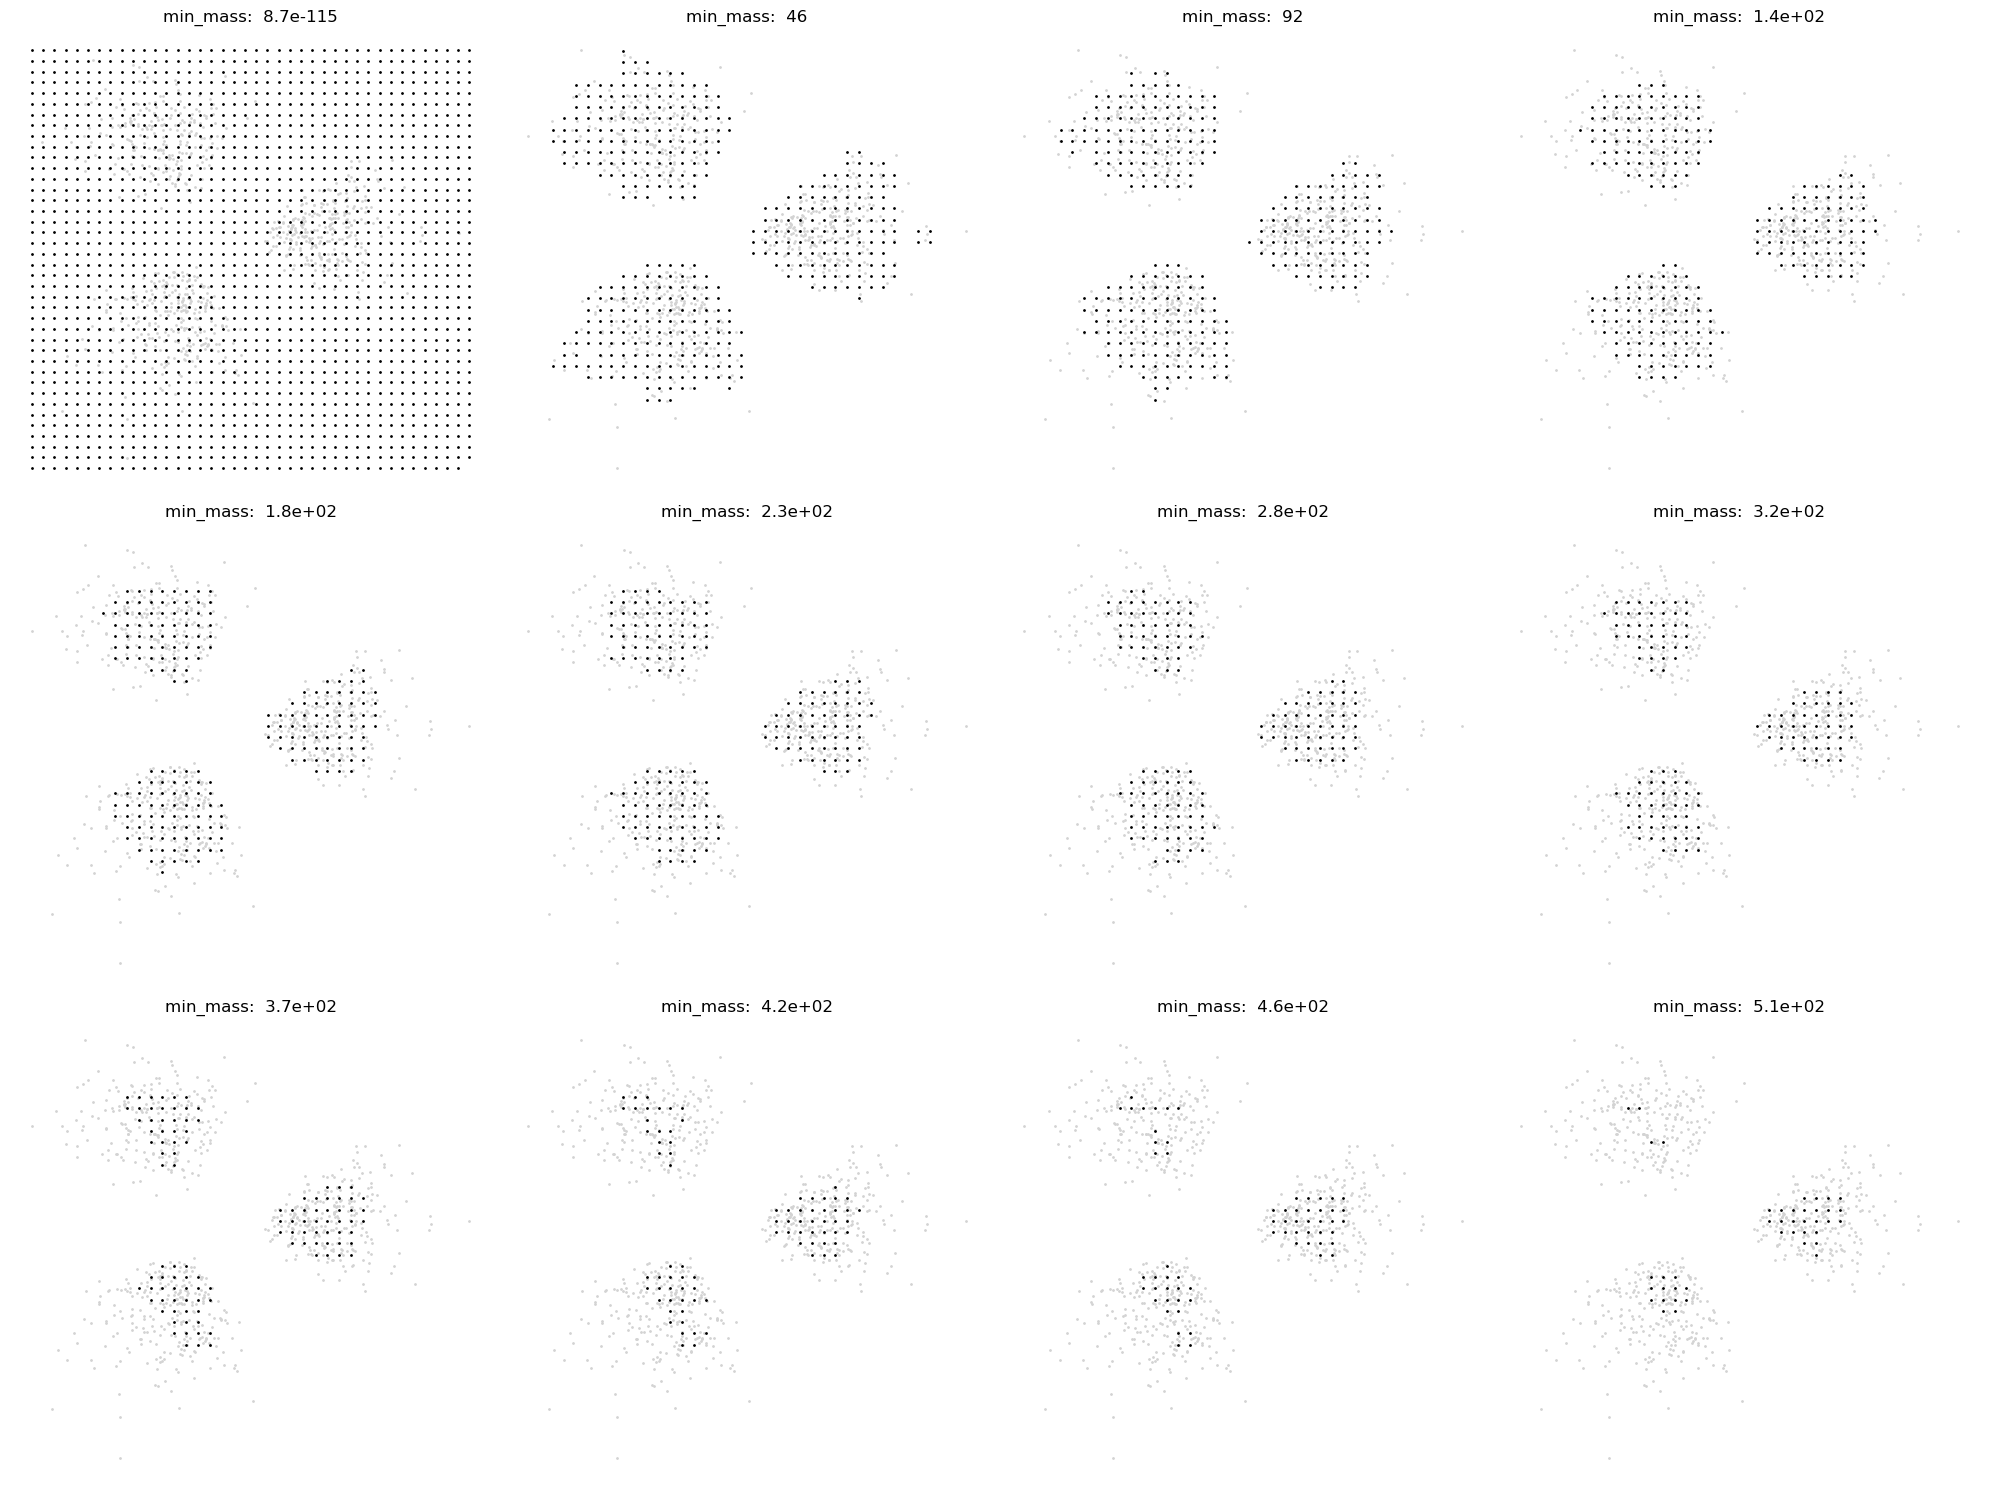

{'latent': array([[ 0.87234896,  0.41851318,  0.6321659 , ..., -0.14993393,
         -0.77338856,  1.0129291 ],
        [ 0.8960528 ,  0.4429687 ,  0.6563627 , ..., -0.18377486,
         -0.7891641 ,  1.0642166 ],
        [ 0.90779454,  0.4996402 ,  0.6420351 , ..., -0.19295777,
         -0.79808027,  1.0737482 ],
        ...,
        [ 0.8530979 ,  0.69189143,  0.6541981 , ..., -0.17758253,
         -0.84053063,  1.0787771 ],
        [ 0.9006763 ,  0.69784844,  0.65957516, ..., -0.16535452,
         -0.79695004,  1.103646  ],
        [ 0.90905553,  0.6968417 ,  0.6645463 , ..., -0.18072896,
         -0.8252583 ,  1.0803803 ]], dtype=float32),
 'logits': array([[-3.78572  , -1.4535887, -3.1040719],
        [-3.7847595, -1.4382637, -3.1230805],
        [-3.7624125, -1.429317 , -3.155819 ],
        ...,
        [-3.6415074, -1.4614007, -3.238915 ],
        [-3.6634293, -1.4288355, -3.255324 ],
        [-3.667913 , -1.4235554, -3.2570584]], dtype=float32),
 'probs': array([[0.07531819, 0.

In [26]:
# 只扰动naive B
pert_plot_vector_field(adata_TF, adata_down, model321_3, pert_Gene,n_neighbors=None,scale=30,pert_celltype=['t2d'],run_suggest_mass_thresholds=True,fold=fold,state_obs='celltype', dot_size=dot_size, min_mass=1.3,embedding_name='X_ct')

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


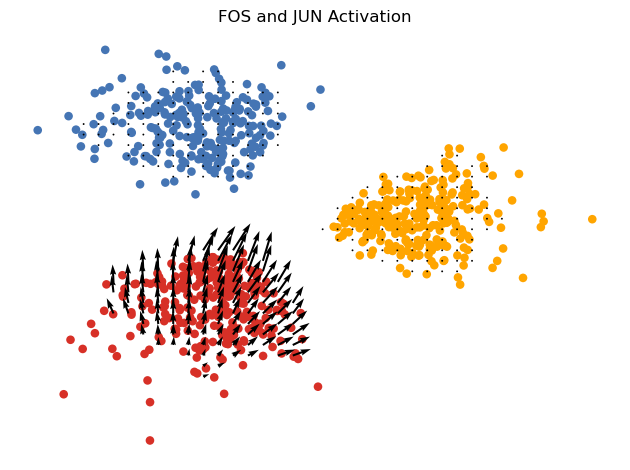

In [83]:
model_output_pert1 = pert_plot_vector_field(adata_TF, adata_down, model321_3, pert_Gene,n_neighbors=None,scale=30,
                                            pert_celltype=['t2d'],run_suggest_mass_thresholds=False,fold=fold,
                                            state_obs='celltype', dot_size=None, min_mass=92,embedding_name='X_ct',
                                            palette = {"control": "#4575B4", "pre": "orange", 't2d': '#D73027'},
                                            save_dir=output_dir, direction='Activation')

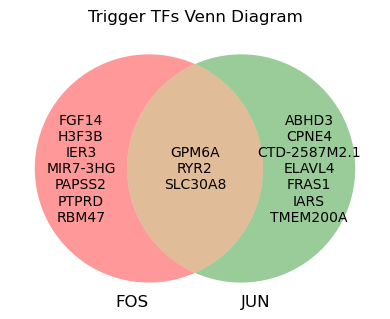

In [85]:
from matplotlib_venn import venn2_unweighted

fos = set(['PAPSS2', 'GPM6A', 'MIR7-3HG', 'FGF14', 'SLC30A8', 'RBM47',
       'H3F3B', 'PTPRD', 'RYR2', 'IER3'])
jun = set(['SLC30A8', 'GPM6A', 'RYR2', 'CTD-2587M2.1', 'ELAVL4', 'ABHD3',
       'IARS', 'FRAS1', 'CPNE4', 'TMEM200A'])


# 画图
plt.figure(figsize=(4, 4))
v = venn2_unweighted([fos, jun], set_labels=('FOS', 'JUN'))

# 填写基因名
regions = {
    '10': fos - jun,
    '01': jun - fos,
    '11': fos & jun
}

for region_id, genes in regions.items():
    label = v.get_label_by_id(region_id)
    if label:
        gene_text = '\n'.join(sorted(genes)) if genes else ''
        label.set_text(gene_text)

plt.title("Trigger TFs Venn Diagram")
plt.tight_layout()
plt.savefig(output_dir + 'TG_venn.pdf')
plt.show()

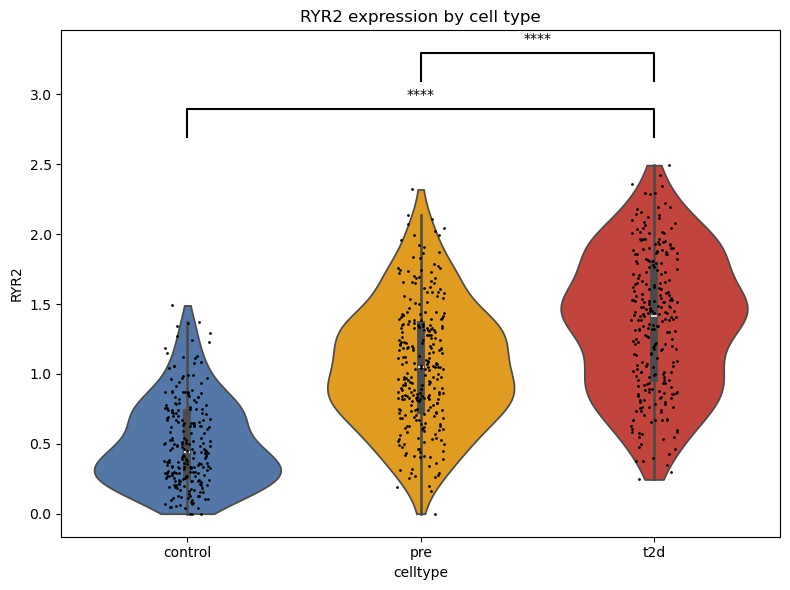

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind




gene = 'RYR2'
expr = adata_down[:, gene].X.toarray().flatten()
celltype = adata_down.obs['celltype'].values


df = pd.DataFrame({f'{gene}': expr, 'celltype': celltype})


plt.figure(figsize=(8, 6))
ax = sns.violinplot(data=df, x='celltype', y=gene, inner='box', cut=0, palette = {"control": "#4575B4", "pre": "orange", 't2d': '#D73027'})
sns.stripplot(data=df, x='celltype', y=gene, color='k', size=2, jitter=True)


group1 = df[df['celltype'] == 'control'][gene]
group2 = df[df['celltype'] == 'pre'][gene]
group3 = df[df['celltype'] == 't2d'][gene]

def get_significance(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

_, pval_13 = ttest_ind(group1, group3, equal_var=False)
_, pval_23 = ttest_ind(group2, group3, equal_var=False)
sig_13 = get_significance(pval_13)
sig_23 = get_significance(pval_23)

y_max = df[gene].max()
h = 0.2
col = 'k'


x1, x3 = 0, 2
plt.plot([x1, x1, x3, x3], [y_max+0.2, y_max+0.4, y_max+0.4, y_max+0.2], lw=1.5, c=col)
plt.text((x1+x3)*.5, y_max+0.45, sig_13, ha='center', va='bottom', color=col)


x2 = 1
plt.plot([x2, x2, x3, x3], [y_max+0.6, y_max+0.8, y_max+0.8, y_max+0.6], lw=1.5, c=col)
plt.text((x2+x3)*.5, y_max+0.85, sig_23, ha='center', va='bottom', color=col)


plt.title(f"{gene} expression by cell type")
plt.tight_layout()
plt.savefig(output_dir + f'{gene}_violin.pdf')
plt.show()

In [73]:
row = sparse_matrix.toarray()[np.where(sparse_matrix_index == 'SLC30A8')[0][0], :]
nonzero_indices = np.where(row != 0)[0]

In [74]:
sparse_matrix_column[nonzero_indices]

array(['8:117745068-117745568', '8:117962120-117962620'], dtype=object)

In [75]:
np.isin(sparse_matrix_column[nonzero_indices], adata3.uns['RE_names'])

array([ True,  True])

In [76]:
geneanno = pd.read_csv('data/hg19_geneanno.txt', sep='\t')
geneanno = geneanno.drop_duplicates(subset=['Gene name'])
geneanno.loc[geneanno['Gene name'] == 'SLC30A8', :]

,Gene stable ID,Transcript stable ID,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Strand,Gene name,Transcription start site (TSS)
170716,ENSG00000164756,ENST00000521243,8,117962512,118188953,1,SLC30A8,117962512


In [169]:
pd.DataFrame({
    'chromosome': 'chr' + geneanno['Chromosome/scaffold name'].astype(str),
    'start': geneanno['Gene start (bp)'],
    'end': geneanno['Gene end (bp)'],
    'strand': geneanno['Strand'].map({1: '+', -1: '-'}),
    'gene': geneanno['Gene stable ID'],
    'transcript': geneanno['Transcript stable ID'],
    'symbol': geneanno['Gene name']
}).to_csv(output_dir+'gene_annotation_sample_converted.csv')